Author: Arend-Jan Quist \
Date created: 12 October 2021\
Last modified: 21 March 2022

Description: This program simulates the quantum algorithm as proposed by C.  Peiker in $\textit{He Gives C-Sieves on the CSIDH}$ (2020). 

To be improved:\
-optimize speed of the program with numba (function summate)\
-add collimation with modulo instead of division (i.e. increase the altitude)\
-use better implementations than/variations of Peikerts algorithm to give better performance of the sieve


In [6]:
import numpy as np
from random import randint, choice, seed
import matplotlib.pyplot as plt
from numba import jit
from scipy.stats import binom

A phase vector is denoted by the tuple $\left([b(0), b(1), \dots, b(L-1)], L\right)$ where $L$ is the length of the phase vector.\
By convention we always have $b(0)=0$.

In [2]:
def gen_phasevecs(N, n=1):
    """Generate n random phase vectors of lenght 2.
    Output: n phase vectors of length 2 on [N].
    
    Parameters:
    N: random multiplier b is between 0 and N.
    n: number of generated phase vectors.
    """
    phase_vec = []
    
    for i in range(n):
        b = randint(0,N-1)
        phase_vec.append((np.array([0,b]),2))
    return phase_vec

#@jit(nopython=True)
def summate2(phasevec):
    """Calculate values b'(j^vec) for combining 2 phase vectors.
    
    Parameter:
    phasevec: tuple of two phasevectors
    
    Example:
    On input (([b_1(0),b_1(1),...,b_1(L-1)], L), ([b_2(0),b_2(1),...,b_2(L'-1)], L'))
    give output [b_1(0)+b_2(0), b_1(0)+b_2(1),..., b_1(1)+b_2(0),...,b_1(L-1)+b_2(L'-1)]
    """
    b = [] # array for values of summed phasevector
    
    for i in range(phasevec[0][1]):
        for j in range(phasevec[1][1]):
            b.append(phasevec[0][0][i] + phasevec[1][0][j])
    
    return b

#@jit
# something goes wrong with numba with types: (b,L) is not understood in some sense
def summate(r, phasevec):
    """Calculate summation values b'(j^vec) for combining r phase vectors.
    
    Output: phase vector (b',L') of r summed phase vectors.
    
    Parameter:
    r: number of phasevectors to be summated
    phasevec: list of r phasevectors
    """
    (b,L) = phasevec[0]
    
    for i in range(1, r): # use recursive combination of 2 phase vectors
        c = ((b,L), phasevec[i])
        b = summate2(c)
        L = L * phasevec[i][1]
    
    return [b,L]

#@jit(nopython=True)
def combine(N, l, phasevec, print_values = False):
    """Combine l phase vectors (of length 2) into a new phase vector on [N].
    
    Output: phase vector (b',L') of r combined phase vectors.
    
    Parameters:
    N: group order
    l: number of combined phase vectors
    phasevec: list of l phasevectors to be combined
    """
    [b,L] = summate(l, phasevec)
    
    b = np.array(b) % N
    
    return [b, L]

#@jit(nopython=True)
def collimate(S, r, phasevec, print_values = False):
    """Collimate r phase vectors into a new phase vector on [S].
    Output: the collimated phase vector ([b(0),b(1),...,b(L'-1)], L') on [S].
    
    Parameters:
    S: output phase vectors has all multipliers on [S]
    r: arity, the number of phase vectors that is collimated
    phasevec: list of phasevectors to be collimated
    
    To be improved: 
    -add scaled interval collimation with modulo measurement
    """
    [b, L] = summate(r, phasevec) # calculate the values of b'(j^vec) in b
            
    q = np.floor_divide(b,S) # calculate values of q = floor(b'(j^vec)/S)
    q_meas = choice(q) # measured value is q_meas
    
    # take values of b with q equals the measured value q_meas
    b_new = np.ma.masked_where(q != q_meas, b).compressed()
    L_new = len(b_new)
    
    b_new = (b_new-b_new[0]) % S # modulo and substract first value to ignore global phase
    # another equivalent option: b_new = b_new - S*q
    
    if print_values:
        #print("b =", b)
        #print("q =", q)
        #print("Measured value q =", q_meas)
        print(phasevec[0][0], " and ", phasevec[1][0], " collimated into ", b_new)
    
    return [b_new, L_new]
    
def calculate_interval_sizes(N, r, L, S_0):
    """Calculate the interval sizes S_0, S_1, S_2, ..., S_d.
    Output: S=[S_0, S_1,..., S_d] and depth d of the sieve.
    
    The values d and S_i are calculated according to section 3.2.1 in Peikert (2020).
    
    This calculation is not needed in the depth-first approach as the interval sizes can be adaptive.
    
    Parameters:
    N: group order
    r: arity of the sieve
    L: wanted length of the output phase vector
    S_0: [S_0] is the range of the output phase vector
    """
    d = int(np.ceil(np.log(N/S_0)/np.log(L**(r-1)/r))) # depth of the sieve
    
    S = np.zeros(d+1,int)
    S[0] = S_0
    S[d] = N
    for i in range(1,d):
        S[i] = int(S[i-1]*L**(r-1)/r)
    
    return S, d
    
    
def sieve(N, r, L, S_0, L_orig = None, print_values=False):
    """Run the collimation sieve from Peikert to get a phase vector of lenght L on S_0.
    
    Parameters:
    N: group order
    r: arity of the sieve
    L: wanted length of the output phase vector
    S_0: [S_0] is the range of the output phase vector
    print_values: boolean to print all intermediate steps when debugging
    
    To be improved:
    -L_prime = 1 gives error now
    -make it working for r>2
    """   
    if L_orig == None:
        L_orig = L
    
    #S, d = calculate_interval_sizes(N, r, L, S_0)
    
    if print_values:
        print("New recursion: Wanted output \nS =",S_0,"\nL =",L)
    
    if L <= 1:
        output_vec = (np.array([0]),1)
    elif S_0 >= N: # base case: create and combine log(L) phase vectors on [N]
        l = int(np.round(np.log2(L)))
        if (l==0):
            l=1
        phase_vec = gen_phasevecs(N,l)
        #print(N, l, phase_vec)
        output_vec = combine(N, l, phase_vec, print_values)
    else:
        S_prime = min(int(np.round(S_0*L_orig**(r-1)/r)),N)
        L_prime = int(np.ceil(L*S_prime/S_0)) # wanted product of phase vector lengths

        if print_values:
            print("S' =",S_prime,"\nL' =",L_prime**(1/r))
            
        phase_vecs = [] # phase vectors to be collimated
        
        L_tilde = 1 # product of lengths of phase vectors so far
        
        for k in range(r): 
            L_wanted = int(np.ceil((L_prime/L_tilde)**(1/(r-k)))) # wanted value of new phase vector
            
            phase_vec_length = 0 # initiate value
            
            # check if new vector is too short or too long (boundaries can be adapted)
            while (phase_vec_length/L_wanted < 0.4 or phase_vec_length/L_wanted > 1/0.4): 
                phase_vec = sieve(N, r, L_wanted, S_prime, L_orig ,print_values) # find new phase vector with wanted length
                phase_vec_length = phase_vec[1]
                
            phase_vecs.append(phase_vec) # add new phase vector to list
        
            L_tilde *= phase_vec[1]
            
        output_vec = collimate(S_0, r, phase_vecs, False)
            
    if print_values:    
        print("Output phase vector of wanted length:",L, " on ", S_0, ": \nlength =",output_vec[1])
    return output_vec

In [9]:
np.random.seed(20220128) # set seed to make things reproducible
seed(20220128)

# Parameters

r = 2  # arity (number of combined phase vectors in collimation)
L = 3000 # wanted length of output phase vector
S_0 = 300  # [S_0] is the range of output phase vector
N = 500000000  # order of group

n=4

phasevectors = []

for i in range(n):
    print("run nr ",i)
    x=sieve(N, r, L, S_0, None,False)
    phasevectors.append(x)
    print(x[1])

run nr  0


C:\Users\Arend-Jan\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in long_scalars


1048
run nr  1
1114
run nr  2
728
run nr  3
1412


In [65]:
"""
# save phase vectors

for i in range(n):
    outfile = "Phasevectors/phasevector_"+str(L)+"_"+str(S_0)+"_"+str(N)+"_"+str(r)+"_"+str(i)+".npz"
    phasevectors[i].append(S_0)
    phasevectors[i].append(N)
    np.savez_compressed(outfile, data=phasevectors[i])

"""

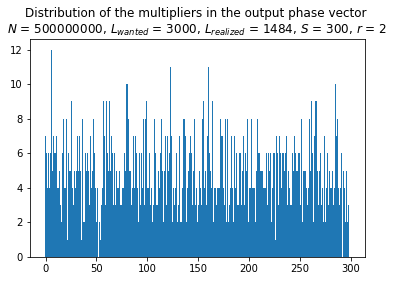

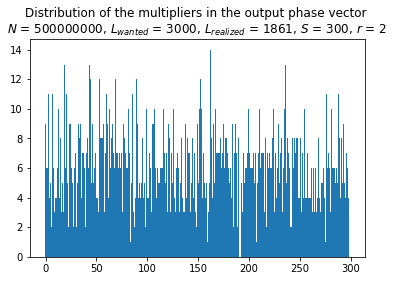

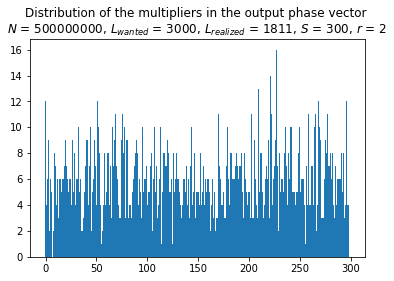

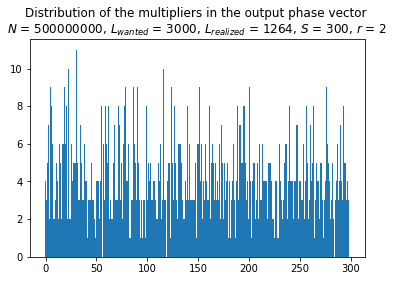

In [40]:
for i in range(n):
    plt.hist(phasevectors[i][0],np.arange(-0.5,S_0-1 +0.5))
    plt.title("Distribution of the multipliers in the output phase vector \n"+
              r"$N$ = "+str(N)+r", $L_{wanted}$ = "+str(L)+r", $L_{realized}$ = "+str(phasevectors[i][1])+
              r", $S$ = "+str(S_0)+r", $r$ = "+str(r))
    
    plt.savefig('Binomial_images/Distribution_multipliers_N='+str(N)+'_L='+str(phasevectors[i][1])+'_S='+str(S_0)+'.pdf')
    plt.show()

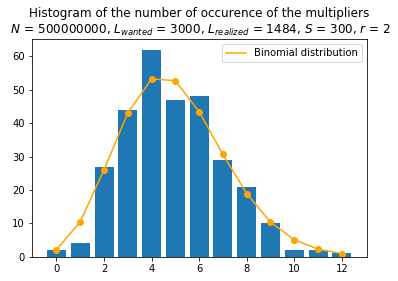

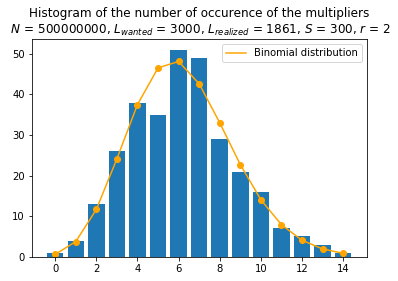

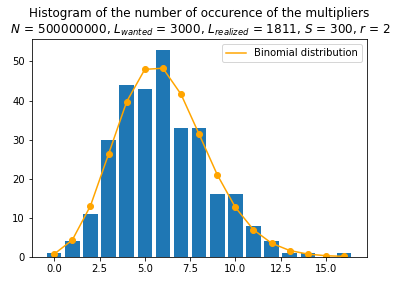

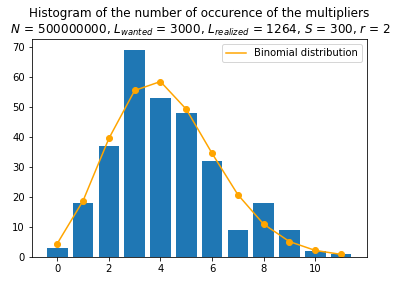

In [41]:
for i in range(n):
    histogram = np.histogram(phasevectors[i][0],np.arange(-0.5,S_0-1 +0.5))
    #print(np.histogram(histogram[0], max(histogram[0])))
    plot_range = np.arange(-0.5,max(histogram[0]+1.5)) #-0.5 might be replaced by min(histogram[0]-0.5)
    histogram2 = np.histogram(histogram[0],plot_range)
    plt.bar(plot_range[:-1]+0.5,histogram2[0])
    
    L_realized = phasevectors[i][1]
    
    # plot binomial distribution
    n_binom = phasevectors[i][1]-1  # L_realized - 1
    p = 1/S_0
    binom_distr = binom.pmf(plot_range[:-1]+0.5,n_binom,p) * S_0
    plt.plot(plot_range[:-1]+0.5,binom_distr,'o',color='orange')
    plt.plot(plot_range[:-1]+0.5,binom_distr,label="Binomial distribution",color='orange')
    
    plt.title("Histogram of the number of occurrence of the multipliers"+
              
              "\n $N$ = "+str(N)+", $L_{wanted}$ = "+str(L)+", $L_{realized}$ = "+str(L_realized)+
              ", $S$ = "+str(S_0)+", $r$ = "+str(r))
    """      
            +
             
              "\n Empirical mean = "+str(np.round(np.mean(histogram[0]),2))+
              ", $(L_{realized}-1)/S$ = "+str(np.round((L_realized-1)/S_0,2))+"\n"+
              
              "Empirical variance = "+str(np.round(np.var(histogram[0]),2))+
              ", $(L_{realized}-1)(S-1)/S^2$ = "+str(np.round((L_realized-1)*(S_0-1)/S_0**2,2))
    """
    plt.legend()
    plt.savefig('Binomial_images/Histogram_multiplier_distribution_N='+str(N)+'_L='+str(L_realized)+'_S='+str(S_0)+'.pdf')
    plt.show()